# This Program is developed by Soheil Hekmat For Q3 part c

Importing Libraries

In [27]:
from gym import Env
from gym.spaces import Discrete
import numpy as np
import random
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

Making The Environment Class

In [3]:
class SoheilEnv(Env):
    def __init__(self):
        # Actions we can take, we can have 3 actions in diameter
        self.action_space = Discrete(3)
        # all states array, not that we have states 1 to 99 but in array it's 0 to 98 so we should use +1 in every use
        self.observation_space = Discrete(99)
        # Set start states s1 and s2
        st = [81,85]
        self.state = random.choice(st)
        # Set maximum step
        self.max_step = 200
        self.grid = [['.' for _ in range(11)] for _ in range(9)]

    def step(self, action):
        # Apply action
        ac =[-1, -11, 1]
        # 0 == -1  Left
        # 1 == -11 forward(up)
        # 2 == 1  Right
        self.state += ac[action]
        # Reduce maximum step by 1 time
        self.max_step -= 1

        # Set a default value for reward in case it's not set in your environment
        reward = 0
        # Calculate reward
        white = [15,16,17,18,19,20,21,24,25,26,27,28,31,32,35,36,37,42,43,47,48,49,50,51,52,53,54,57,58,62,63,68,69,70,71,72,73,74,75,76,79,80,81,82,84,85,86,87]
        gray = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,22,23,30,33,34,38,39,40,41,44,45,46,55,56,59,60,61,64,65,66,67,77,78,83,88,89,90,91,92,93,94,95,96,97,98,99]
        green = 29
        re = [-2,-1]
        rs = [-3,-2]
        # if self.state in white:
        #     reward =-1
        if action == 0:
            reward = random.choice(rs)
        if action == 1 or action == 2:
            reward = random.choice(re)
        if self.state in gray:
            reward = -5
        if self.state == green:
            reward = 10

        # Check if path finding is done
        if self.state in gray or self.state == green:
            done = True
        else:
            done = False

        # Set placeholder for info
        info = {}

        # Return step information
        return self.state, reward, done, info

    def render(self):
        for row in range(9):
          for col in range(11):
            if row == 0 or row == 8 or col == 0 or col ==10:
              self.grid[row][col] = 'X'
            if (row,col) == (1,1) or (row,col) == (1,2) or (row,col) == (2,7) or (row,col) == (3,4) or (row,col) == (3,5) or (row,col) == (3,6) or (row,col) == (3,7):
              self.grid[row][col] = 'X'
            if (row,col) == (4,1) or (row,col) == (5,3) or (row,col) == (5,4) or (row,col) == (5,5) or (row,col) == (5,8) or (row,col) == (5,9) or (row,col) == (7,5):
              self.grid[row][col] = 'X'
        for i in range(9):
          for j in range(11):
            if (i,j) == (3-1,7-1):
              print('G', end=' ')
            if (i,j) == (8-1,4-1):
              print('S', end=' ')
            if (i,j) == (8-1,8-1):
              print('S', end=' ')
            if (i,j) != (8-1,8-1) and (i,j) != (8-1,4-1) and (i,j) != (3-1,7-1):
              print(self.grid[i][j], end=' ')
          print()
        print()
    def reset(self):
        # Reset robot's position to s1 or s2
        st = [81,85]
        self.state = random.choice(st)
        # Reset max step
        self.max_step = 200
        # Initialize the grid with special characters
        # for i in range(9):
        #     for j in range(11):
        #         for cell, symbol in self.special_cells:
        #             if (i, j) == cell:
        #                 self.grid[i][j] = symbol

        # Return state adjusted to the range 1 to 99 (descrete(99) is 0 to 98)
        return self.state + 1


Environment calling

In [4]:
env = SoheilEnv()

In [5]:
env.action_space.sample()
#env.observation_space.sample() + 1

2

Testing some actions and rewards

In [65]:
episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{} FinalState:{}'.format(episode, score, n_state))

Episode:1 Score:-56 FinalState:7
Episode:2 Score:-21 FinalState:61
Episode:3 Score:-12 FinalState:64
Episode:4 Score:-18 FinalState:61
Episode:5 Score:-10 FinalState:61
Episode:6 Score:-8 FinalState:64
Episode:7 Score:-25 FinalState:23
Episode:8 Score:-31 FinalState:41
Episode:9 Score:-32 FinalState:59
Episode:10 Score:-7 FinalState:60


# Visualization

In [8]:
env.render()

X X X X X X X X X X X 
X X X . . . . . . . X 
X . . . . . G X . . X 
X . . . X X X X . . X 
X X . . . . . . . . X 
X . . X X X . . X X X 
X . . . . . . . . . X 
X . . S . X . S . . X 
X X X X X X X X X X X 



In [9]:
env.action_space.n

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3

QLearning

Hyperparameters

In [61]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.05         # Learning rate(alpha)

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
gamma = 1                 # Discounting rate

# Exploration parameters
eps = 0.1

Creating Q table

In [38]:
# Let's create our Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [55]:
def train(n_training_episodes, eps, env, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        # initialize epsilon
        epsilon = eps
        # Reset the environment
        state = env.reset()
        step = 0
        terminated = False

        while not terminated:
          ######################################### Step 2 #################################
            # Choose the action (A_t) using epsilon greedy policy:
            random_num = random.uniform(0,1)
            # if random_num > greater than epsilon --> exploitation
            if random_num > epsilon:
                # Take the action with the highest value given a state
                # np.argmax can be useful here
                action = np.argmax(Qtable[state, :])
            # else --> exploration
            else:
                action = env.action_space.sample()

          ######################################### Step 3 #################################
            # Take action A_t and observe R_t+1 and S_t+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, info = env.step(action)
            # step_result = env.step(action)
            # new_state, reward, terminated, info = step_result[:4]
            # state = int(state)
            # action = int(action)
            # new_state = int(new_state)

          ######################################### Step 4 #################################
            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state, action] = Qtable[state, action] + learning_rate * (reward + gamma * np.max(Qtable[new_state, :]) - Qtable[state, action])

            # If terminated or truncated finish the episode
            if terminated:
                break

            # Our next state is the new state
            state = new_state
    return Qtable

using QLearning we try reaching the goal 5 times

In [68]:
num_try = 5
Qtable_ = np.zeros([num_try, env.observation_space.n, env.action_space.n])
for i in range(num_try):
  Qtable = initialize_q_table(env.observation_space.n, env.action_space.n)
  Qtable_[i,:,:] = train(n_training_episodes, eps, env, Qtable)

100%|██████████| 10000/10000 [00:00<00:00, 20275.93it/s]


Because Qtable is 99 rows you only can see it if you set num_try to 1 or 2. if you set it more than that it will summerize the table and you cant see the values

In [67]:
Qtable_

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-1.13109531, -1.13109531, -1.11238256],
        [-0.9754517 , -1.32454055, -0.99857031],
        [-0.89183514, -0.92746875, -0.93495582],
        [-1.02009366, -1.13109531, -0.93455361],
        [-1.38761237, -1.32454055, -1.3498794 ],
        [-2.1360783 

# Evaluation

In [58]:
def evaluate_agent(env, n_eval_episodes, Qtable):
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):

    state = env.reset()
    step = 0
    terminated = False
    total_rewards_ep = 0

    while not terminated:
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Qtable[state, :])
      new_state, reward, terminated, info = env.step(action)

      total_rewards_ep += reward

      if terminated:
        break
      state = new_state

    episode_rewards.append(total_rewards_ep)

  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward, episode_rewards

In [62]:
# Evaluate our Agent
for i in range(Qtable_.shape[0]):
  mean_reward, std_reward, episode_rewards = evaluate_agent(env, n_eval_episodes, Qtable_[i,:,:])
  print(f"\nMean_reward = {mean_reward:.2f} +/- {std_reward:.2f}\n")

100%|██████████| 100/100 [00:00<00:00, 32140.26it/s]



Mean_reward = -6.87 +/- 0.72



100%|██████████| 100/100 [00:00<00:00, 27917.36it/s]



Mean_reward = -6.87 +/- 0.70



100%|██████████| 100/100 [00:00<00:00, 37752.51it/s]



Mean_reward = -6.89 +/- 0.75



100%|██████████| 100/100 [00:00<00:00, 34970.02it/s]



Mean_reward = -7.11 +/- 0.71



100%|██████████| 100/100 [00:00<00:00, 38522.26it/s]


Mean_reward = -6.94 +/- 0.76



# Plotting and Visualizing

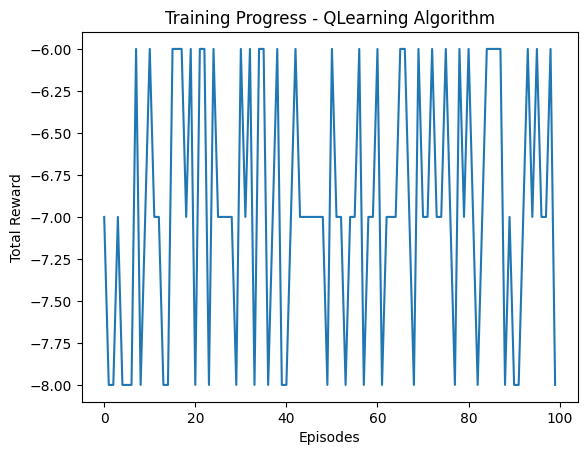

In [63]:
# Plotting the rewards
plt.plot(episode_rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Training Progress - QLearning Algorithm')
plt.show()

# Path

Best Path to reach the Goal From one of S! or S2. note that i have defined the starting point randomly from s1 or s2 which is harder to code

In [64]:
# Print sequence of actions that has taken to reach the goal
Actions =  {0: 'Left',
            1: 'Forward',
            2: 'Right'}
Qtable_selected = Qtable_[2]
action_sequence=[]
for j in range(Qtable_selected.shape[0]):
    action_sequence.append(Actions[np.argmax(np.array(Qtable_selected)[j, :])])
print(' --> '.join(action_sequence))

Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Right --> Forward --> Right --> Left --> Right --> Left --> Right --> Left --> Left --> Right --> Right --> Right --> Right --> Right --> Left --> Left --> Right --> Right --> Left --> Left --> Forward --> Right --> Forward --> Left --> Left --> Left --> Left --> Left --> Right --> Left --> Left --> Left --> Forward --> Forward --> Left --> Left --> Right --> Forward --> Forward --> Forward --> Left --> Left --> Forward --> Forward --> Left --> Left --> Left --> Left --> Right --> Left --> Left --> Left --> Left --> Left --> Forward --> Forward --> Forward --> Forward --> Forward --> Forward --> Forward --> Right --> Left --> Left --> Left --> Left --> Forward --> Forward --> Left --> Left --> Left --> Left --> Right --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left --> Left
